<a href="https://colab.research.google.com/github/GBowenli/MiniProject-2-Multi-Class-Logistic-Regression-and-Gradient-Descent/blob/main/SoftmaxRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
from sklearn.datasets import fetch_openml
iris = fetch_openml(name='iris',version=1)
from sklearn.datasets import load_digits
digits = load_digits()
warnings.filterwarnings('ignore')

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e3, epsilon=1e-8, batches=10, momentum=0.9, T=20):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batches = batches
        self.momentum = momentum
        self.T = T
        self.previous_grad = 0
        self.training_accuracy_history = []
        self.validation_accuracy_history = []
        self.w_history = []
            
    def run(self, gradient_fn, accuracy_function, x_train, y_train, x_validation, y_validation, w):
        grad = np.inf
        t = 0

        mini_batches_x = np.array_split(x_train, self.batches)                                # split x and y in to mini batches
        mini_batches_y = np.array_split(y_train, self.batches)

        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            batch_index = t % self.batches                                                    # find the index of the mini batch
            x_batch = mini_batches_x[batch_index]                                             # set x and y batches
            y_batch = mini_batches_y[batch_index]

            total_grad = np.zeros(w.shape)
            total_points = 0
            
            for iter in range(len(y_batch)):                                                  # calculate summation the gradients of each point in the mini batch
                x_batch_point = x_batch[iter, :]
                x_batch_point = x_batch_point[:, None].T
                y_batch_point = y_batch[iter, :]
                y_batch_point = y_batch_point[:, None].T
                total_grad += gradient_fn(x_batch_point, y_batch_point, w)
                total_points += 1

            grad = total_grad / total_points                                                  # divide by total_points to obtain mini batch gradient
            grad = self.momentum * self.previous_grad + (1 - self.momentum) * grad            # apply momentum to gradient
            self.previous_grad = grad                                                         # set previous_grad to grad for next iteration

            w = w - self.learning_rate * grad                                                 # weight update step
          
            training_error = accuracy_function(x_train, y_train, w)                           # calculate training and validation error
            self.training_accuracy_history.append(training_error)
            validation_error = accuracy_function(x_validation, y_validation, w)
            self.validation_accuracy_history.append(validation_error)
            self.w_history.append(w)

            if len(self.validation_accuracy_history) >= self.T:                                              # check if validation accuracy history is big enough
                most_recent_validation_accuracy_history = self.validation_accuracy_history[-1 * self.T:]     # take most T most recent validation accuracies
                if np.all(np.diff(most_recent_validation_accuracy_history) <= 0):                            # check if accuracies are decreasing
                    return self.w_history[np.argmin(self.validation_accuracy_history)]                       # if errors are decreasing, return most recent w as that is the lowest validation error
            t += 1
        return w

In [ ]:
class LogisticClassifier:
    def __init__(self, add_bias=True, add_regularization=False, lambdaa=0.01):
        self.add_bias = add_bias
        self.add_regularization = add_regularization
        self.lambdaa = lambdaa
            
    def fit(self, x_train, y_train, x_validation, y_validation, optimizer):
        if x_train.ndim == 1:
            x_train = x_train[:, None]
        if x_validation.ndim == 1:
            x_validation = x_validation[:, None]
        if self.add_bias:
            x_train = np.column_stack([x_train,np.ones(x_train.shape[0])])
            x_validation = np.column_stack([x_validation,np.ones(x_validation.shape[0])])

        def softmax(z):                                                                           # define the softmax function
            z -= z.max(axis=1, keepdims = True)
            return np.exp(z) / np.exp(z).sum(axis=1)[:,None]

        def gradient(x, y, w):                                                                    # define the gradient function
            z = x @ w
            yh = softmax(z)
            return x.T @ (yh - y)

        def gradient_with_reg(x, y, w):                                                           # define the gradient function with L2 regularization
            z = x @ w
            yh = softmax(z)
            grad = x.T @ (yh - y)

            regularization = self.lambdaa * w
            if self.add_bias:
                regularization[-1, :] = 0
            return grad + regularization

        def softmax_cross_entropy(x, y, w):                                                       # define the softmax cross entropy function
            z = x @ w                                                                             # calculate z
            cross_entropy = 0

            for n in range(y.shape[0]):                                                           # loop through each data point
                z_max = np.max(z[n, :])                                                           # find the max value of z at the nth row
                log_sum_exp = z_max + np.log(np.sum(np.exp(z[n, :] - z_max)))                     # calculate log sum exp with trick to prevent over/underflowing
                cross_entropy += z[n, :] @ y[n, :].T - log_sum_exp                                # add to cross entropy
            return -1 * cross_entropy

        def accuracy(x, y, w):                                                                    # define the accuracy function
            z = x @ w

            total_matched = 0;

            if (z==np.zeros(z.shape)).all():
                return 0;
            else:
                for n in range(y.shape[0]):
                    if np.argmax(z[n, :]) == np.argmax(y[n, :]):
                        total_matched += 1

                return total_matched / y.shape[0]

        
        w0 = np.zeros((x_train.shape[1], y_train.shape[1]))                                                                 # initialize the weights to 0

        if self.add_regularization:
            self.w = optimizer.run(gradient_with_reg, accuracy, x_train, y_train, x_validation, y_validation, w0)           # run the optimizer to get the optimal weights
        else:
            self.w = optimizer.run(gradient, accuracy, x_train, y_train, x_validation, y_validation, w0)                    # run the optimizer to get the optimal weights
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh


Digits 5 Fold (Grid search)

In [ ]:
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
from sklearn import preprocessing
from matplotlib import pyplot as plt

digits = load_digits()

#one hot encode categorical data
target = digits.target
target = target[:, None]
enc = preprocessing.OneHotEncoder()
enc.fit(target)
onehotlabels = enc.transform(target).toarray()

X = digits.data
y = onehotlabels 
fold_size = int(X.shape[0]//5)

learning_rate_hyperparameters = [0.01, 0.1, 1];
batches_hyperparameters = [5, 10, 20];
momentum_hyperparameters = [0.5, 0.9, 1];

for i in range(5):
    if i != 0 or i != 4:
        X_train = X[0:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(5-i)*fold_size]

        y_train = y[0:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(5-i)*fold_size]

        X_train = np.concatenate((X_train,X[(5-i)*fold_size:]), axis = 0)
        y_train = np.concatenate((y_train,y[(5-i)*fold_size:]), axis = 0)
  
    else:
        X_train = X[(i//4)*fold_size:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(i//4)*fold_size]

        y_train = y[(i//4)*fold_size:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(i//4)*fold_size]

    best_validation_accuracy = 0;
    best_learning_rate = 0;
    best_batches = 0;
    best_momentum = 0;

    for learning_rate in learning_rate_hyperparameters:
        for batches in batches_hyperparameters:
            for momentum in momentum_hyperparameters:
                optimizer = GradientDescent(learning_rate=learning_rate, batches=batches, momentum=momentum)
                model = LogisticClassifier(add_regularization=False)
                model.fit(X_train, y_train, X_val, y_val, optimizer)

                current_validation_accuracy = 0
                if len(optimizer.validation_accuracy_history) == 1000:
                    current_validation_accuracy = optimizer.validation_accuracy_history[-1]
                else:
                    current_validation_accuracy = np.max(optimizer.validation_accuracy_history);

                if current_validation_accuracy > best_validation_accuracy:
                    best_validation_accuracy = current_validation_accuracy
                    best_optimizer = optimizer
                    best_learning_rate = learning_rate
                    best_batches = batches
                    best_momentum = momentum

    training_accuracy_history_title = "Training Accuracy History (learning rate: {} batches: {} momentum: {})".format(best_learning_rate, best_batches, best_momentum)
    validation_accuracy_history_title = "Validation Accuracy History (learning rate: {} batches: {} momentum: {})".format(best_learning_rate, best_batches, best_momentum)

    fig = plt.figure()
    plt.plot(best_optimizer.training_accuracy_history)
    fig.suptitle(training_accuracy_history_title)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()

    fig = plt.figure()
    plt.plot(best_optimizer.validation_accuracy_history)
    fig.suptitle(validation_accuracy_history_title)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()

Digits 5 Fold (hyperparameter tuning)

In [ ]:
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
from sklearn import preprocessing
from matplotlib import pyplot as plt

digits = load_digits()

target = digits.target
target = target[:, None]
results = []
enc = preprocessing.OneHotEncoder()
enc.fit(target)

onehotlabels = enc.transform(target).toarray()

X = digits.data
y = onehotlabels 
fold_size = int(X.shape[0]//5)

learning_rate_hyperparameter = [1, 0.1, 0.01];
batches_hyperparameter = [5, 10, 20];
momentum_hyperparameter = [1, 0.9, 0.5]
regularization_hyperparameter = [0.01, 0.1, 0];

for i in range(5):
    if i != 0 or i != 4:
        X_train = X[0:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(5-i)*fold_size]

        y_train = y[0:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(5-i)*fold_size]

        X_train = np.concatenate((X_train,X[(5-i)*fold_size:]), axis = 0)
        y_train = np.concatenate((y_train,y[(5-i)*fold_size:]), axis = 0)
  
    else:
        X_train = X[(i//4)*fold_size:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(i//4)*fold_size]

        y_train = y[(i//4)*fold_size:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(i//4)*fold_size]

    # lambdaa testing
    regularization_training_accuracy = [];
    regularization_validation_accuracy = [];
    for lambdaa in regularization_hyperparameter:
        optimizer = GradientDescent(learning_rate=0.1, batches=5, momentum=0.9)
        model = LogisticClassifier(add_regularization=True, lambdaa=lambdaa)
        model.fit(X_train, y_train, X_val, y_val, optimizer)
        regularization_training_accuracy.append(optimizer.training_accuracy_history)
        regularization_validation_accuracy.append(optimizer.validation_accuracy_history)

    fig = plt.figure()
    for i in range(len(regularization_training_accuracy)):
          plt.plot(regularization_training_accuracy[i], label=regularization_hyperparameter[i])
    fig.suptitle('Training Accuracy History With Varying Lambdaa')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure()
    for i in range(len(regularization_training_accuracy)):
          plt.plot(regularization_validation_accuracy[i], label=regularization_hyperparameter[i])
    fig.suptitle('Validation Accuracy History With Varying Lambdaa')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    # learning rate testing
    learning_rate_training_accuracy = [];
    learning_rate_vaidation_accuracy = [];
    for learning_rate in learning_rate_hyperparameter:
        optimizer = GradientDescent(learning_rate=learning_rate, batches=5, momentum=0.9)
        model = LogisticClassifier(add_regularization=True, lambdaa=0.01)
        model.fit(X_train, y_train, X_val, y_val, optimizer)
        learning_rate_training_accuracy.append(optimizer.training_accuracy_history)
        learning_rate_vaidation_accuracy.append(optimizer.validation_accuracy_history)

    fig = plt.figure()
    for i in range(len(learning_rate_training_accuracy)):
          plt.plot(learning_rate_training_accuracy[i], label=learning_rate_hyperparameter[i])
    fig.suptitle('Training Accuracy History With Varying Learning Rate')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure()
    for i in range(len(learning_rate_vaidation_accuracy)):
          plt.plot(learning_rate_vaidation_accuracy[i], label=learning_rate_hyperparameter[i])
    fig.suptitle('Validation Accuracy History With Varying Learning Rate')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    # batches testing
    batches_training_accuracy = [];
    batches_vaidation_accuracy = [];
    for batches in batches_hyperparameter:
        optimizer = GradientDescent(learning_rate=0.1, batches=batches, momentum=0.9)
        model = LogisticClassifier(add_regularization=True, lambdaa=0.01)
        model.fit(X_train, y_train, X_val, y_val, optimizer)
        batches_training_accuracy.append(optimizer.training_accuracy_history)
        batches_vaidation_accuracy.append(optimizer.validation_accuracy_history)

    fig = plt.figure()
    for i in range(len(batches_training_accuracy)):
          plt.plot(batches_training_accuracy[i], label=batches_hyperparameter[i])
    fig.suptitle('Training Accuracy History With Varying Batches')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure()
    for i in range(len(batches_vaidation_accuracy)):
          plt.plot(batches_vaidation_accuracy[i], label=batches_hyperparameter[i])
    fig.suptitle('Validation Accuracy History With Varying Batches')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    # # momentum testing
    momentum_training_accuracy = [];
    momentum_vaidation_accuracy = [];
    for momentum in momentum_hyperparameter:
        optimizer = GradientDescent(learning_rate=0.1, batches=5, momentum=momentum)
        model = LogisticClassifier(add_regularization=True, lambdaa=0.01)
        model.fit(X_train, y_train, X_val, y_val, optimizer)
        momentum_training_accuracy.append(optimizer.training_accuracy_history)
        momentum_vaidation_accuracy.append(optimizer.validation_accuracy_history)

    fig = plt.figure()
    for i in range(len(momentum_training_accuracy)):
          plt.plot(momentum_training_accuracy[i], label=momentum_hyperparameter[i])
    fig.suptitle('Training Accuracy History With Varying Momentum')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure()
    for i in range(len(momentum_vaidation_accuracy)):
          plt.plot(momentum_vaidation_accuracy[i], label=momentum_hyperparameter[i])
    fig.suptitle('Validation Accuracy History With Varying Momentum')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    # optimal model
    # optimizer = GradientDescent(learning_rate=0.1, batches=5, momentum=0.9)
    # model = LogisticClassifier(add_regularization=True, lambdaa=0.01)
    # model.fit(X_train, y_train, X_val, y_val, optimizer)

    # fig = plt.figure()
    # plt.plot(optimizer.training_accuracy_history)
    # fig.suptitle("Training Accuracy History (learning rate: 0.01 batches: 5 momentum: 0.9 lambda: 0.01)")
    # plt.xlabel('Iterations')
    # plt.ylabel('Accuracy')
    # plt.show()

    # fig = plt.figure()
    # plt.plot(optimizer.validation_accuracy_history)
    # fig.suptitle("Validation Accuracy History (learning rate: 0.01 batches: 5 momentum: 0.9 lambda: 0.01)")
    # plt.xlabel('Iterations')
    # plt.ylabel('Accuracy')
    # plt.show()





Digits 5 Fold (Hyperparameters vs Time)

In [ ]:
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
from sklearn import preprocessing
from matplotlib import pyplot as plt
import time

digits = load_digits()

target = digits.target
target = target[:, None]
results = []
enc = preprocessing.OneHotEncoder()
enc.fit(target)

onehotlabels = enc.transform(target).toarray()

X = digits.data
y = onehotlabels 
fold_size = int(X.shape[0]//5)

learning_rate_hyperparameter = [0.01, 0.1, 1, 10, 100];
batches_hyperparameter = [5, 10, 20, 40, 80];
momentum_hyperparameter = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
regularization_hyperparameter = [0.01, 0.1, 0, 1, 10];

for i in range(5):
    if i != 0 or i != 4:
        X_train = X[0:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(5-i)*fold_size]

        y_train = y[0:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(5-i)*fold_size]

        X_train = np.concatenate((X_train,X[(5-i)*fold_size:]), axis = 0)
        y_train = np.concatenate((y_train,y[(5-i)*fold_size:]), axis = 0)
  
    else:
        X_train = X[(i//4)*fold_size:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(i//4)*fold_size]

        y_train = y[(i//4)*fold_size:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(i//4)*fold_size]

    # learning rate
    eclapsed_time_learning_rate = [];
    for learning_rate in learning_rate_hyperparameter:
        start_time = time.time()

        optimizer = GradientDescent(learning_rate=learning_rate, batches=5, momentum=0.9)
        model = LogisticClassifier(add_regularization=True, lambdaa=0.01)
        model.fit(X_train, y_train, X_val, y_val, optimizer)

        end_time = time.time()
        elapsed_time = end_time - start_time
        eclapsed_time_learning_rate.append(elapsed_time);
    
    fig = plt.figure()
    fig.suptitle('Learning Rate vs Elapsed Time')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(list(map(str, learning_rate_hyperparameter)), eclapsed_time_learning_rate)
    ax.set_ylabel('Elapsed Time (seconds)')
    ax.set_xlabel('Learning Rates')
    plt.show()

    # batches
    eclapsed_time_batches = [];
    for batches in batches_hyperparameter:
        start_time = time.time()

        optimizer = GradientDescent(learning_rate=0.1, batches=batches, momentum=0.9)
        model = LogisticClassifier(add_regularization=True, lambdaa=0.01)
        model.fit(X_train, y_train, X_val, y_val, optimizer)

        end_time = time.time()
        elapsed_time = end_time - start_time
        eclapsed_time_batches.append(elapsed_time);
    
    fig = plt.figure()
    fig.suptitle('Batches vs Elapsed Time')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(list(map(str, batches_hyperparameter)), eclapsed_time_batches)
    ax.set_ylabel('Elapsed Time (seconds)')
    ax.set_xlabel('Batches')
    plt.show()

    # momentum
    eclapsed_time_momentum = [];
    for momentum in momentum_hyperparameter:
        start_time = time.time()

        optimizer = GradientDescent(learning_rate=0.1, batches=5, momentum=momentum)
        model = LogisticClassifier(add_regularization=True, lambdaa=0.01)
        model.fit(X_train, y_train, X_val, y_val, optimizer)

        end_time = time.time()
        elapsed_time = end_time - start_time
        eclapsed_time_momentum.append(elapsed_time);

    fig = plt.figure()
    fig.suptitle('Momentum vs Elapsed Time')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(list(map(str, momentum_hyperparameter)), eclapsed_time_momentum)
    ax.set_ylabel('Elapsed Time (seconds)')
    ax.set_xlabel('Momentum')
    plt.show()   

    # regularization
    eclapsed_time_regularization = [];
    for lambdaa in regularization_hyperparameter:
        start_time = time.time()

        optimizer = GradientDescent(learning_rate=0.1, batches=5, momentum=0.9)
        model = LogisticClassifier(add_regularization=True, lambdaa=lambdaa)
        model.fit(X_train, y_train, X_val, y_val, optimizer)

        end_time = time.time()
        elapsed_time = end_time - start_time
        eclapsed_time_regularization.append(elapsed_time);

    fig = plt.figure()
    fig.suptitle('Regularization vs Elapsed Time')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(list(map(str, regularization_hyperparameter)), eclapsed_time_regularization)
    ax.set_ylabel('Elapsed Time (seconds)')
    ax.set_xlabel('Lambda')
    plt.show()   





Iris 5 Fold (Grid Search)

In [ ]:
from sklearn.utils import shuffle
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
from matplotlib import pyplot as plt

#import dataset
iris = fetch_openml(name='iris',version=1)

#one hot encode categorical data
target = iris.target
target = target[:, None]
enc = preprocessing.OneHotEncoder()
enc.fit(target)
onehotlabels = enc.transform(target).toarray()

#5 fold cross validation
X = iris.data
y = onehotlabels 
fold_size = int(X.shape[0]//5)

learning_rate_hyperparameters = [0.01, 0.1, 1];
batches_hyperparameters = [5, 10, 20];
momentum_hyperparameters = [0.5, 0.9, 1];

for i in range(5):
    if i != 0 or i != 4:
        X_train = X[0:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(5-i)*fold_size]

        y_train = y[0:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(5-i)*fold_size]

        X_train = np.concatenate((X_train,X[(5-i)*fold_size:]), axis = 0)
        y_train = np.concatenate((y_train,y[(5-i)*fold_size:]), axis = 0)
  
    else:
        X_train = X[(i//4)*fold_size:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(i//4)*fold_size]

        y_train = y[(i//4)*fold_size:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(i//4)*fold_size]

    best_validation_accuracy = 0;
    best_learning_rate = 0;
    best_batches = 0;
    best_momentum = 0;

    #testing different hyperparameters
    for learning_rate in learning_rate_hyperparameters:
        for batches in batches_hyperparameters:
            for momentum in momentum_hyperparameters:
                optimizer = GradientDescent(learning_rate=learning_rate, batches=batches, momentum=momentum, max_iters=10000, T=500)
                model = LogisticClassifier(add_regularization=False)
                model.fit(X_train, y_train, X_val, y_val, optimizer)

                current_validation_accuracy = 0
                if len(optimizer.validation_accuracy_history) == 1000:
                    current_validation_accuracy = optimizer.validation_accuracy_history[-1]
                else:
                    current_validation_accuracy = np.max(optimizer.validation_accuracy_history);

                if current_validation_accuracy > best_validation_accuracy:
                    best_validation_accuracy = current_validation_accuracy
                    best_optimizer = optimizer
                    best_learning_rate = learning_rate
                    best_batches = batches
                    best_momentum = momentum
    #plotting
    training_accuracy_history_title = "Training Accuracy History (learning rate: {} batches: {} momentum: {})".format(best_learning_rate, best_batches, best_momentum)
    validation_accuracy_history_title = "Validation Accuracy History (learning rate: {} batches: {} momentum: {})".format(best_learning_rate, best_batches, best_momentum)

    fig = plt.figure()
    plt.plot(best_optimizer.training_accuracy_history)
    fig.suptitle(training_accuracy_history_title)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()

    fig = plt.figure()
    plt.plot(best_optimizer.validation_accuracy_history)
    fig.suptitle(validation_accuracy_history_title)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()


Iris 5 Fold (hyperparameter tuning)

In [ ]:
from sklearn.utils import shuffle
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
from matplotlib import pyplot as plt

#fetch data
iris = fetch_openml(name='iris',version=1)

#one hot encoding
target = iris.target
target = target[:, None]
enc = preprocessing.OneHotEncoder()
enc.fit(target)

onehotlabels = enc.transform(target).toarray()

X = iris.data
y = onehotlabels 
fold_size = int(X.shape[0]//5)

learning_rate_hyperparameter = [1, 0.1, 0.01];
batches_hyperparameter = [20, 10, 5];
momentum_hyperparameter = [0.5, 0.9, 1]
regularization_hyperparameter = [0.01, 0.1, 0];

#5 fold cross validation
for i in range(5):
    if i != 0 or i != 4:
        X_train = X[0:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(5-i)*fold_size]

        y_train = y[0:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(5-i)*fold_size]

        X_train = np.concatenate((X_train,X[(5-i)*fold_size:]), axis = 0)
        y_train = np.concatenate((y_train,y[(5-i)*fold_size:]), axis = 0)
  
    else:
        X_train = X[(i//4)*fold_size:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(i//4)*fold_size]

        y_train = y[(i//4)*fold_size:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(i//4)*fold_size]

    # lambdaa testing
    regularization_training_accuracy = [];
    regularization_validation_accuracy = [];
    for lambdaa in regularization_hyperparameter:
        optimizer = GradientDescent(learning_rate=0.01, batches=5, momentum=0.5, max_iters=10000, T=500)
        model = LogisticClassifier(add_regularization=True, lambdaa=lambdaa)
        model.fit(X_train, y_train, X_val, y_val, optimizer)
        regularization_training_accuracy.append(optimizer.training_accuracy_history)
        regularization_validation_accuracy.append(optimizer.validation_accuracy_history)

    fig = plt.figure()
    for i in range(len(regularization_training_accuracy)):
          plt.plot(regularization_training_accuracy[i], label=regularization_hyperparameter[i])
    fig.suptitle('Training Accuracy History With Varying Lambdaa')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure()
    for i in range(len(regularization_training_accuracy)):
          plt.plot(regularization_validation_accuracy[i], label=regularization_hyperparameter[i])
    fig.suptitle('Validation Accuracy History With Varying Lambdaa')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    # learning rate testing
    learning_rate_training_accuracy = [];
    learning_rate_vaidation_accuracy = [];
    for learning_rate in learning_rate_hyperparameter:
        optimizer = GradientDescent(learning_rate=learning_rate, batches=5, momentum=0.5, max_iters=10000, T=500)
        model = LogisticClassifier(add_regularization=False)
        model.fit(X_train, y_train, X_val, y_val, optimizer)
        learning_rate_training_accuracy.append(optimizer.training_accuracy_history)
        learning_rate_vaidation_accuracy.append(optimizer.validation_accuracy_history)

    fig = plt.figure()
    for i in range(len(learning_rate_training_accuracy)):
          plt.plot(learning_rate_training_accuracy[i], label=learning_rate_hyperparameter[i])
    fig.suptitle('Training Accuracy History With Varying Learning Rate')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure()
    for i in range(len(learning_rate_vaidation_accuracy)):
          plt.plot(learning_rate_vaidation_accuracy[i], label=learning_rate_hyperparameter[i])
    fig.suptitle('Validation Accuracy History With Varying Learning Rate')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    # batches testing
    batches_training_accuracy = [];
    batches_vaidation_accuracy = [];
    for batches in batches_hyperparameter:
        optimizer = GradientDescent(learning_rate=0.01, batches=batches, momentum=0.5, max_iters=10000, T=500)
        model = LogisticClassifier(add_regularization=False)
        model.fit(X_train, y_train, X_val, y_val, optimizer)
        batches_training_accuracy.append(optimizer.training_accuracy_history)
        batches_vaidation_accuracy.append(optimizer.validation_accuracy_history)

    fig = plt.figure()
    for i in range(len(batches_training_accuracy)):
          plt.plot(batches_training_accuracy[i], label=batches_hyperparameter[i])
    fig.suptitle('Training Accuracy History With Varying Batches')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure()
    for i in range(len(batches_vaidation_accuracy)):
          plt.plot(batches_vaidation_accuracy[i], label=batches_hyperparameter[i])
    fig.suptitle('Validation Accuracy History With Varying Batches')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    # # momentum testing
    momentum_training_accuracy = [];
    momentum_vaidation_accuracy = [];
    for momentum in momentum_hyperparameter:
        optimizer = GradientDescent(learning_rate=0.01, batches=5, momentum=momentum, max_iters=10000, T=500)
        model = LogisticClassifier(add_regularization=False)
        model.fit(X_train, y_train, X_val, y_val, optimizer)
        momentum_training_accuracy.append(optimizer.training_accuracy_history)
        momentum_vaidation_accuracy.append(optimizer.validation_accuracy_history)

    fig = plt.figure()
    for i in range(len(momentum_training_accuracy)):
          plt.plot(momentum_training_accuracy[i], label=momentum_hyperparameter[i])
    fig.suptitle('Training Accuracy History With Varying Momentum')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure()
    for i in range(len(momentum_vaidation_accuracy)):
          plt.plot(momentum_vaidation_accuracy[i], label=momentum_hyperparameter[i])
    fig.suptitle('Validation Accuracy History With Varying Momentum')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    # optimal model
    # optimizer = GradientDescent(learning_rate=0.01, batches=5, momentum=0.9, max_iters=10000, T=1000)
    # model = LogisticClassifier(add_regularization=False)
    # model.fit(X_train, y_train, X_val, y_val, optimizer)

    # #plotting
    # fig = plt.figure()
    # plt.plot(optimizer.training_accuracy_history)
    # fig.suptitle("Training Accuracy History (learning rate: 0.01 batches: 5 momentum: 0.9 lambda: 0)")
    # plt.xlabel('Iterations')
    # plt.ylabel('Accuracy')
    # plt.show()

    # fig = plt.figure()
    # plt.plot(optimizer.validation_accuracy_history)
    # fig.suptitle("Validation Accuracy History (learning rate: 0.01 batches: 5 momentum: 0.9 lambda: 0)")
    # plt.xlabel('Iterations')
    # plt.ylabel('Accuracy')
    # plt.show()



Iris 5 Fold (Hyperparameters vs Time)

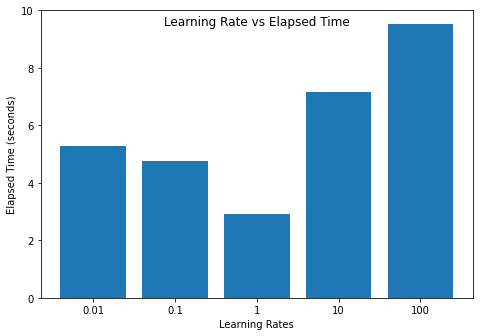

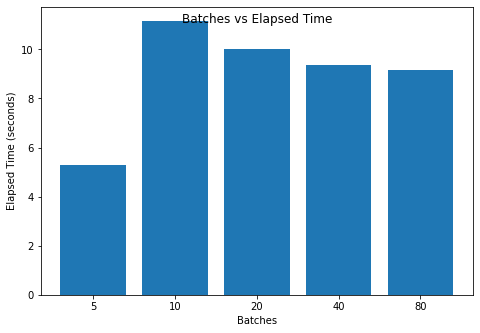

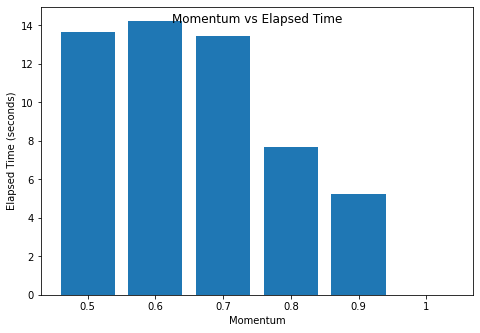

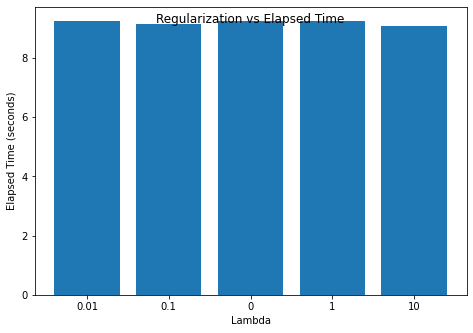

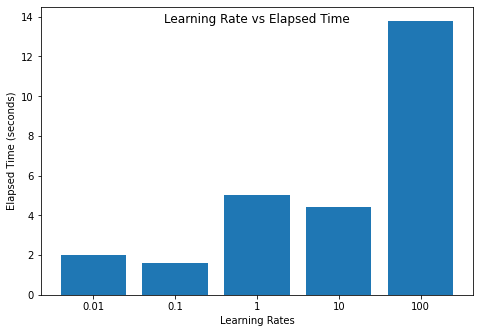

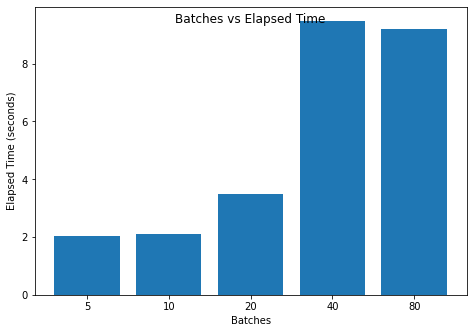

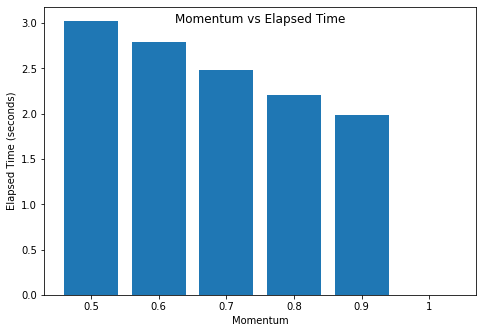

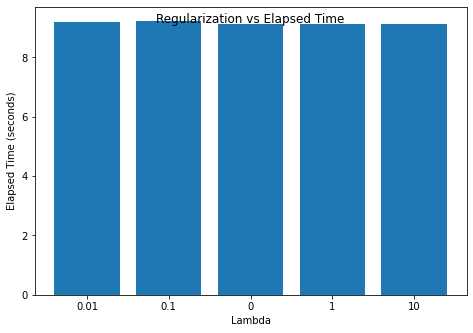

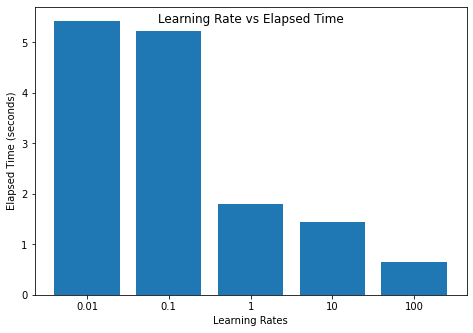

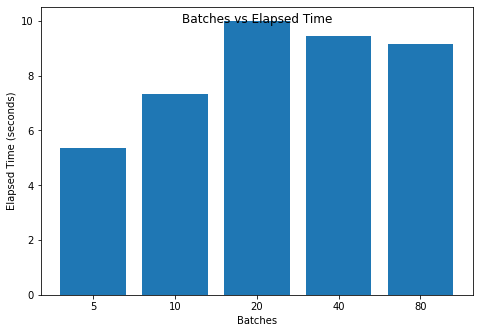

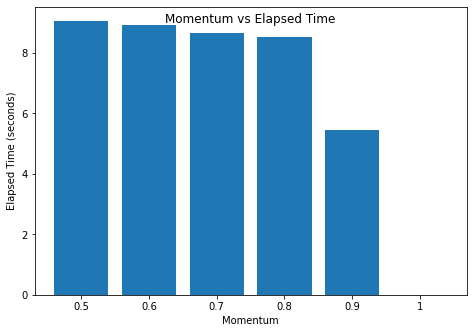

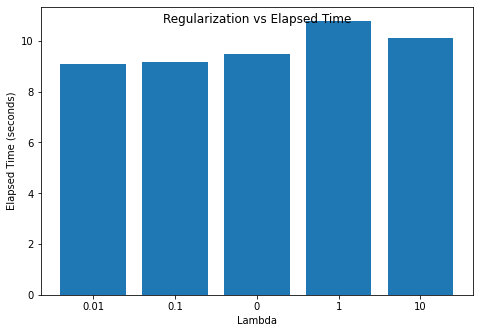

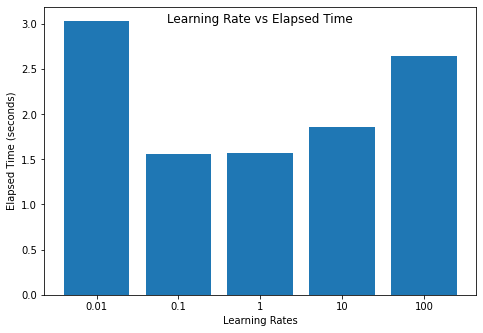

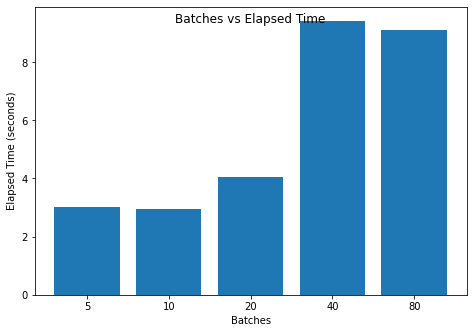

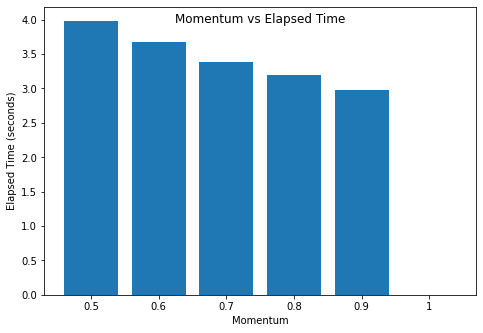

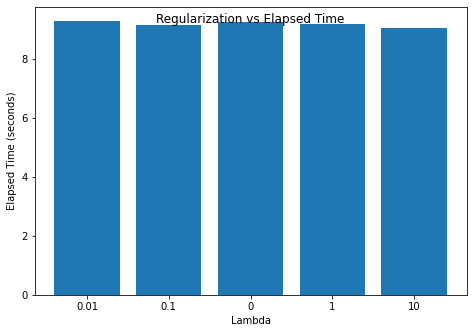

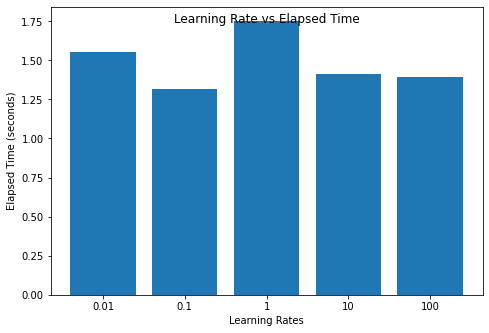

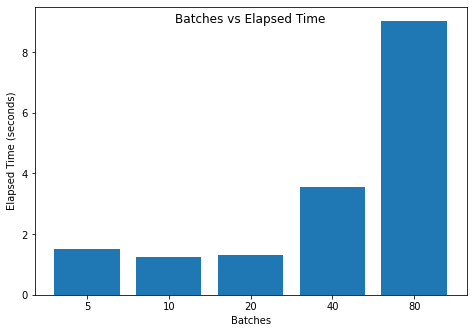

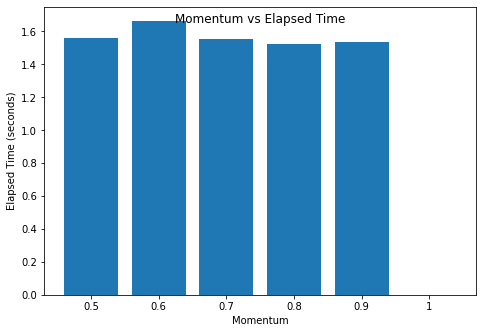

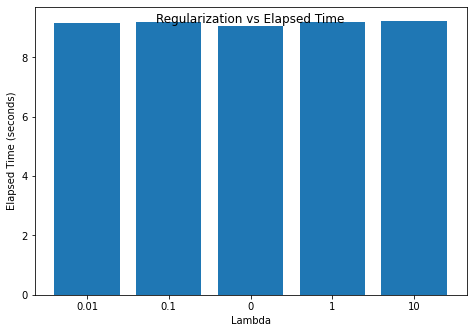

In [ ]:
from sklearn.utils import shuffle
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
from matplotlib import pyplot as plt

#fetch data
iris = fetch_openml(name='iris',version=1)

#one hot encoding
target = iris.target
target = target[:, None]
enc = preprocessing.OneHotEncoder()
enc.fit(target)

onehotlabels = enc.transform(target).toarray()

#5 fold cross validation
X = iris.data
y = onehotlabels 
fold_size = int(X.shape[0]//5)

#varying hyperparameters
learning_rate_hyperparameter = [0.01, 0.1, 1, 10, 100];
batches_hyperparameter = [5, 10, 20, 40, 80];
momentum_hyperparameter = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
regularization_hyperparameter = [0.01, 0.1, 0, 1, 10];

for i in range(5):
    if i != 0 or i != 4:
        X_train = X[0:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(5-i)*fold_size]

        y_train = y[0:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(5-i)*fold_size]

        X_train = np.concatenate((X_train,X[(5-i)*fold_size:]), axis = 0)
        y_train = np.concatenate((y_train,y[(5-i)*fold_size:]), axis = 0)
  
    else:
        X_train = X[(i//4)*fold_size:fold_size*(4-i)]
        X_val   = X[(4-i)*fold_size:(i//4)*fold_size]

        y_train = y[(i//4)*fold_size:fold_size*(4-i)]
        y_val   = y[(4-i)*fold_size:(i//4)*fold_size]

    # learning rate
    eclapsed_time_learning_rate = [];
    for learning_rate in learning_rate_hyperparameter:
        start_time = time.time()

        optimizer = GradientDescent(learning_rate=learning_rate, batches=5, momentum=0.9, max_iters=10000, T=1000)
        model = LogisticClassifier(add_regularization=False)
        model.fit(X_train, y_train, X_val, y_val, optimizer)

        end_time = time.time()
        elapsed_time = end_time - start_time
        eclapsed_time_learning_rate.append(elapsed_time);
    
    #plotting
    fig = plt.figure()
    fig.suptitle('Learning Rate vs Elapsed Time')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(list(map(str, learning_rate_hyperparameter)), eclapsed_time_learning_rate)
    ax.set_ylabel('Elapsed Time (seconds)')
    ax.set_xlabel('Learning Rates')
    plt.show()

    # batches
    eclapsed_time_batches = [];
    for batches in batches_hyperparameter:
        start_time = time.time()

        optimizer = GradientDescent(learning_rate=0.01, batches=batches, momentum=0.9, max_iters=10000, T=1000)
        model = LogisticClassifier(add_regularization=False)
        model.fit(X_train, y_train, X_val, y_val, optimizer)

        end_time = time.time()
        elapsed_time = end_time - start_time
        eclapsed_time_batches.append(elapsed_time);
    
    #plotting
    fig = plt.figure()
    fig.suptitle('Batches vs Elapsed Time')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(list(map(str, batches_hyperparameter)), eclapsed_time_batches)
    ax.set_ylabel('Elapsed Time (seconds)')
    ax.set_xlabel('Batches')
    plt.show()

    # momentum
    eclapsed_time_momentum = [];
    for momentum in momentum_hyperparameter:
        start_time = time.time()

        optimizer = GradientDescent(learning_rate=0.01, batches=5, momentum=momentum, max_iters=10000, T=1000)
        model = LogisticClassifier(add_regularization=False)
        model.fit(X_train, y_train, X_val, y_val, optimizer)

        end_time = time.time()
        elapsed_time = end_time - start_time
        eclapsed_time_momentum.append(elapsed_time);

    fig = plt.figure()
    fig.suptitle('Momentum vs Elapsed Time')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(list(map(str, momentum_hyperparameter)), eclapsed_time_momentum)
    ax.set_ylabel('Elapsed Time (seconds)')
    ax.set_xlabel('Momentum')
    plt.show()   

    # regularization
    eclapsed_time_regularization = [];
    for lambdaa in regularization_hyperparameter:
        start_time = time.time()

        optimizer = GradientDescent(learning_rate=0.01, batches=batches, momentum=0.9, max_iters=10000, T=1000)
        model = LogisticClassifier(add_regularization=True, lambdaa=lambdaa)
        model.fit(X_train, y_train, X_val, y_val, optimizer)

        end_time = time.time()
        elapsed_time = end_time - start_time
        eclapsed_time_regularization.append(elapsed_time);

    fig = plt.figure()
    fig.suptitle('Regularization vs Elapsed Time')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(list(map(str, regularization_hyperparameter)), eclapsed_time_regularization)
    ax.set_ylabel('Elapsed Time (seconds)')
    ax.set_xlabel('Lambda')
    plt.show()   


In [ ]:
#Digits dataset and KNN - 5-fold cross validation

In [ ]:
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets, neighbors
np.random.seed(1234)

In [ ]:
# import the necessary packages
from __future__ import print_function
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure
import numpy as np
import imutils
import cv2
import sklearn
from sklearn.model_selection import train_test_split
 
# load the MNIST digits dataset
mnist = datasets.load_digits()
 
# take the MNIST data and construct the training and testing split, using 75% of the
# data for training and 25% for testing
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(mnist.data),
	mnist.target, test_size=0.25, random_state=42)
 
# show the sizes of each data split
print("training data points: {}".format(len(trainLabels)))
#print("validation data points: {}".format(len(valLabels)))
print("testing data points: {}".format(len(testLabels)))

training data points: 1347
testing data points: 450


In [ ]:
x, y = datasets.load_digits(return_X_y=True)
(num_instances, num_features), num_classes = x.shape, np.max(y)+1
print(num_instances, num_features, num_classes)

1797 64 10


In [ ]:
#define a function for the accucay
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [ ]:
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

In [ ]:
n_test, n_valid = num_instances // 5, num_instances // 5
inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
x_valid, y_valid = x[inds[n_test:n_test+n_valid]], y[inds[n_test:n_test+n_valid]]
x_train, y_train = x[inds[n_test+n_valid:]], y[inds[n_test+n_valid:]]
n_rest = num_instances - n_test

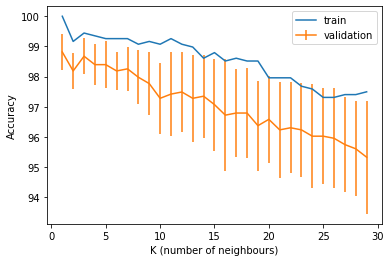

In [ ]:
#use the cross-validation to find the best set of hyper-parameters
K_list = range(1,30)
num_folds = 5
err_train, err_valid = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        model = KNeighborsClassifier(n_neighbors=K)
        model = model.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = accuracy_metric(y_rest[val],model.predict(x_rest[val]))
    model = KNeighborsClassifier(n_neighbors=K)
    model = model.fit(x_rest, y_rest)
    err_train[i]= accuracy_metric(y_train,model.predict(x_train))
    
plt.plot(K_list, err_train,  label='train')
plt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# re-train our classifier using the best k value and predict the labels of the
# test data
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainData, trainLabels)
predictions = model.predict(testData)
 
# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits
print("EVALUATION ON TESTING DATA")
print(classification_report(testLabels, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.97      1.00      0.99        37
           2       1.00      1.00      1.00        38
           3       0.98      1.00      0.99        46
           4       0.98      1.00      0.99        55
           5       0.98      1.00      0.99        59
           6       1.00      1.00      1.00        45
           7       1.00      0.98      0.99        41
           8       0.97      0.97      0.97        38
           9       0.98      0.92      0.95        48

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



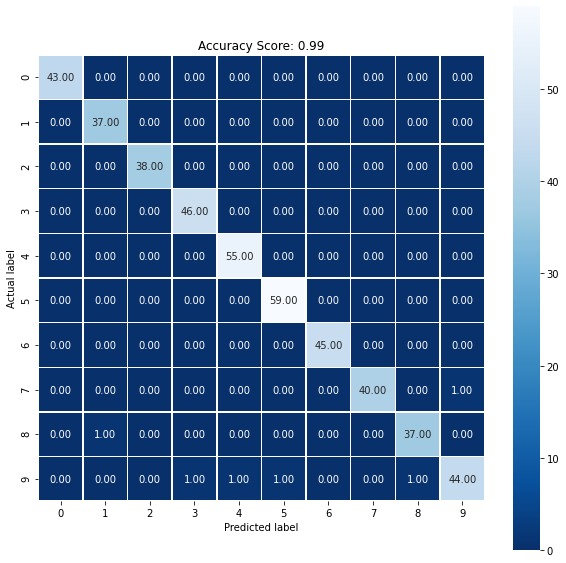

In [ ]:
from sklearn import metrics
import seaborn as sns
 
cm = metrics.confusion_matrix(testLabels, predictions)
score = model.score(x_test, y_test) 
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Accuracy Score: {score:.2f}'
plt.title(all_sample_title, size = 12)
plt.show()

In [ ]:
#Iris and KNN - 5-fold cross validation

In [ ]:
# import random search, random forest, iris data, and distributions
from sklearn import datasets
np.random.seed(1234)
# get iris data
iris = datasets.load_iris()
X2 = iris.data
y2 = iris.target

In [ ]:
(num_instances2, num_features2), num_classes2 = X2.shape, np.max(y2)+1
print(num_instances2, num_features2, num_classes2)
n_test2, n_valid2 = num_instances2 // 5, num_instances2 // 5
n_rest2 = num_instances2 - n_test2
inds = np.random.permutation(num_instances2)
x_test2, y_test2 = X2[inds[:n_test2]], y2[inds[:n_test2]]
x_rest2, y_rest2 = X2[inds[n_test2:]], y2[inds[n_test2:]]
x_valid2, y_valid2 = X2[inds[n_test2:n_test2+n_valid2]], y2[inds[n_test2:n_test2+n_valid2]]
x_train2, y_train2 = X2[inds[n_test2+n_valid2:]], y2[inds[n_test2+n_valid2:]]


150 4 3


In [ ]:
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

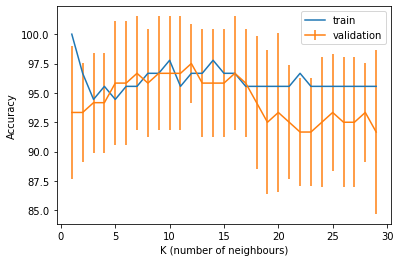

In [ ]:
#use the cross-validation to find the best set of hyper-parameters
K_list = range(1,30)
num_folds = 5
err_train2, err_valid2 = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest2, num_folds)):
        model = KNeighborsClassifier(n_neighbors=K)
        model = model.fit(x_rest2[tr], y_rest2[tr])
        err_valid2[i, f] = accuracy_metric(y_rest2[val],model.predict(x_rest2[val]))
    model = KNeighborsClassifier(n_neighbors=K)
    model = model.fit(x_rest2, y_rest2)
    err_train2[i]= accuracy_metric(y_train2,model.predict(x_train2))
    
plt.plot(K_list, err_train2,  label='train')
plt.errorbar(K_list, np.mean(err_valid2, axis=1), np.std(err_valid2, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model2 = KNeighborsClassifier(n_neighbors=12)
model2.fit(x_train2, y_train2)
predictions2=model2.predict(x_test2)

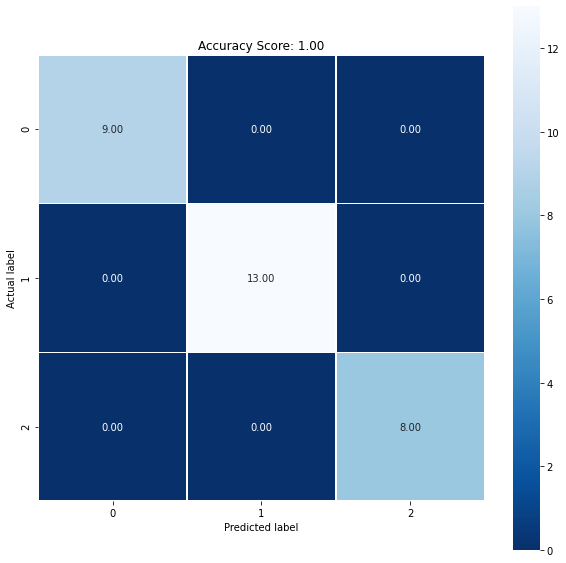

In [ ]:
from sklearn import metrics
import seaborn as sns
cm2 = metrics.confusion_matrix(y_test2, predictions2)
score2 = model2.score(x_test2, y_test2) 
plt.figure(figsize=(10,10))
sns.heatmap(cm2, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Accuracy Score: {score2:.2f}'
plt.title(all_sample_title, size = 12)
plt.show()